# Advanced Regression Techniques - Ames, IA Housing Data

The purpose of this project is to determine the price of housing in the city of Ames, IA using real estate data and different regression models: Decision Tree, Random Forest, XGBoost Regression

Features such as Lot Size, Number of Bedrooms and the Age of the House are used to determine the price of real estate. Each feature
will be evaluated later for its importance in the regression models (Feature Importance).


## RMSE

Root Mean Squared Error (RMSE) is the method of Regression that will be selected to predict real estate prices using real estate features. According to Wikipedia, RMSE is defined as the following:

The root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or the effect values) predicted by a model or an estimator and the values observed. The RMSD represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences. These deviations are called residuals when the calculations are performed over the The effect sample that was used for estimation and are called errors (or The effect errors) when computed out-of-sample. The RMSD serves to aggregate the magnitudes of the errors in predictions for various data points into a single measure of predictive power. RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.[1]

**RMSD** serves to aggregate the magnitudes of the errors in predictions for various data points into a single measure of predictive power. **RMSD** is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.[1]

**RMSD** is the square root of the average of squared errors. The effect of each error on **RMSD** is proportional to the size of the squared error; thus larger errors have a disproportionately large  effect on **RMSD**. Consequently, **RMSD** is sensitive to outliers. Thus, it is wise to consider identifying and removing outlier values in order to make RMSD effective!

# Data Description

In [1]:
"""
Data Description:

       NA	No Garage
              
       GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
              
       PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
              
       WoodDeckSF: Wood deck area in square feet

       OpenPorchSF: Open porch area in square feet

       EnclosedPorch: Enclosed porch area in square feet

       3SsnPorch: Three season porch area in square feet

       ScreenPorch: Screen porch area in square feet

       PoolArea: Pool area in square feet

       PoolQC: Pool quality
              
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
              
       Fence: Fence quality
              
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

       MiscFeature: Miscellaneous feature not covered in other categories
              
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
              
       MiscVal: $Value of miscellaneous feature

       MoSold: Month Sold (MM)

       YrSold: Year Sold (YYYY)

       SaleType: Type of sale
              
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
              
       SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
"""

'\nData Description:\n\n       NA\tNo Garage\n              \n       GarageCond: Garage condition\n\n       Ex\tExcellent\n       Gd\tGood\n       TA\tTypical/Average\n       Fa\tFair\n       Po\tPoor\n       NA\tNo Garage\n              \n       PavedDrive: Paved driveway\n\n       Y\tPaved \n       P\tPartial Pavement\n       N\tDirt/Gravel\n              \n       WoodDeckSF: Wood deck area in square feet\n\n       OpenPorchSF: Open porch area in square feet\n\n       EnclosedPorch: Enclosed porch area in square feet\n\n       3SsnPorch: Three season porch area in square feet\n\n       ScreenPorch: Screen porch area in square feet\n\n       PoolArea: Pool area in square feet\n\n       PoolQC: Pool quality\n              \n       Ex\tExcellent\n       Gd\tGood\n       TA\tAverage/Typical\n       Fa\tFair\n       NA\tNo Pool\n              \n       Fence: Fence quality\n              \n       GdPrv\tGood Privacy\n       MnPrv\tMinimum Privacy\n       GdWo\tGood Wood\n       MnWw\tMinim

# Import libraries

In [2]:
try:
    %reload_ext autotime
except:
    %pip install ipython-autotime
    %load_ext autotime

time: 0 ns (started: 2022-02-21 17:08:48 -07:00)


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

time: 0 ns (started: 2022-02-21 17:08:48 -07:00)


In [4]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.offline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
  
# import sklearn machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE, RFECV

%pip install shap
import shap

%pip install xgboost
from xgboost import plot_importance

%pip install category_encoders

# XGBoost ML libraries
import math
from xgboost import XGBRegressor
from xgboost import plot_importance

# Formatting options
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
time: 19.5 s (started: 2022-02-21 17:08:48 -07:00)


# Data Loading and EDA

In [5]:
# import the training dataset

url = 'https://github.com/patty-olanterns/RealEstateAmesIA/blob/main/train.csv?raw=true'
df = pd.read_csv(url, low_memory=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


time: 1.23 s (started: 2022-02-21 17:09:08 -07:00)


In [6]:
# check the data structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Drop the Id column
df.drop('Id', axis=1, inplace=True)

time: 0 ns (started: 2022-02-21 17:09:10 -07:00)


In [8]:
object_cols = ['MSSubClass', 'MSZoning'] 
df[object_cols] = df[object_cols].astype('object')

# Convert all int and float64 to float32
num_cols = df.select_dtypes(exclude=['object']).columns
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce', downcast='float')

time: 31 ms (started: 2022-02-21 17:09:10 -07:00)


Check the number of attributes with Missing Values

In [9]:
# Check for null data and sort by the top 10 columns
df.isnull().sum(axis=0).sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
MSSubClass         0
dtype: int64

time: 16 ms (started: 2022-02-21 17:09:10 -07:00)


19/80 attributes are missing values. These cells can be filled in with imputation
or other methods or deleted.

# Exploratory Data Analysis

## Is there a correlation (+ or -) between specific house features and the SalePrice?

Example:
 - Does a renovation increase the SalePrice?
 - By how much?
 - How much of an impact does the GarageSize(1 car, 2 car) have on the SalePrice?
   

In [10]:
# Display top 10 positively correlated features with target (SalePrice)
df.corrwith(df['SalePrice']).sort_values(ascending=False).head(11)

SalePrice      1.000
OverallQual    0.791
GrLivArea      0.709
GarageCars     0.640
GarageArea     0.623
TotalBsmtSF    0.614
1stFlrSF       0.606
FullBath       0.561
TotRmsAbvGrd   0.534
YearBuilt      0.523
YearRemodAdd   0.507
dtype: float64

time: 47 ms (started: 2022-02-21 17:09:10 -07:00)


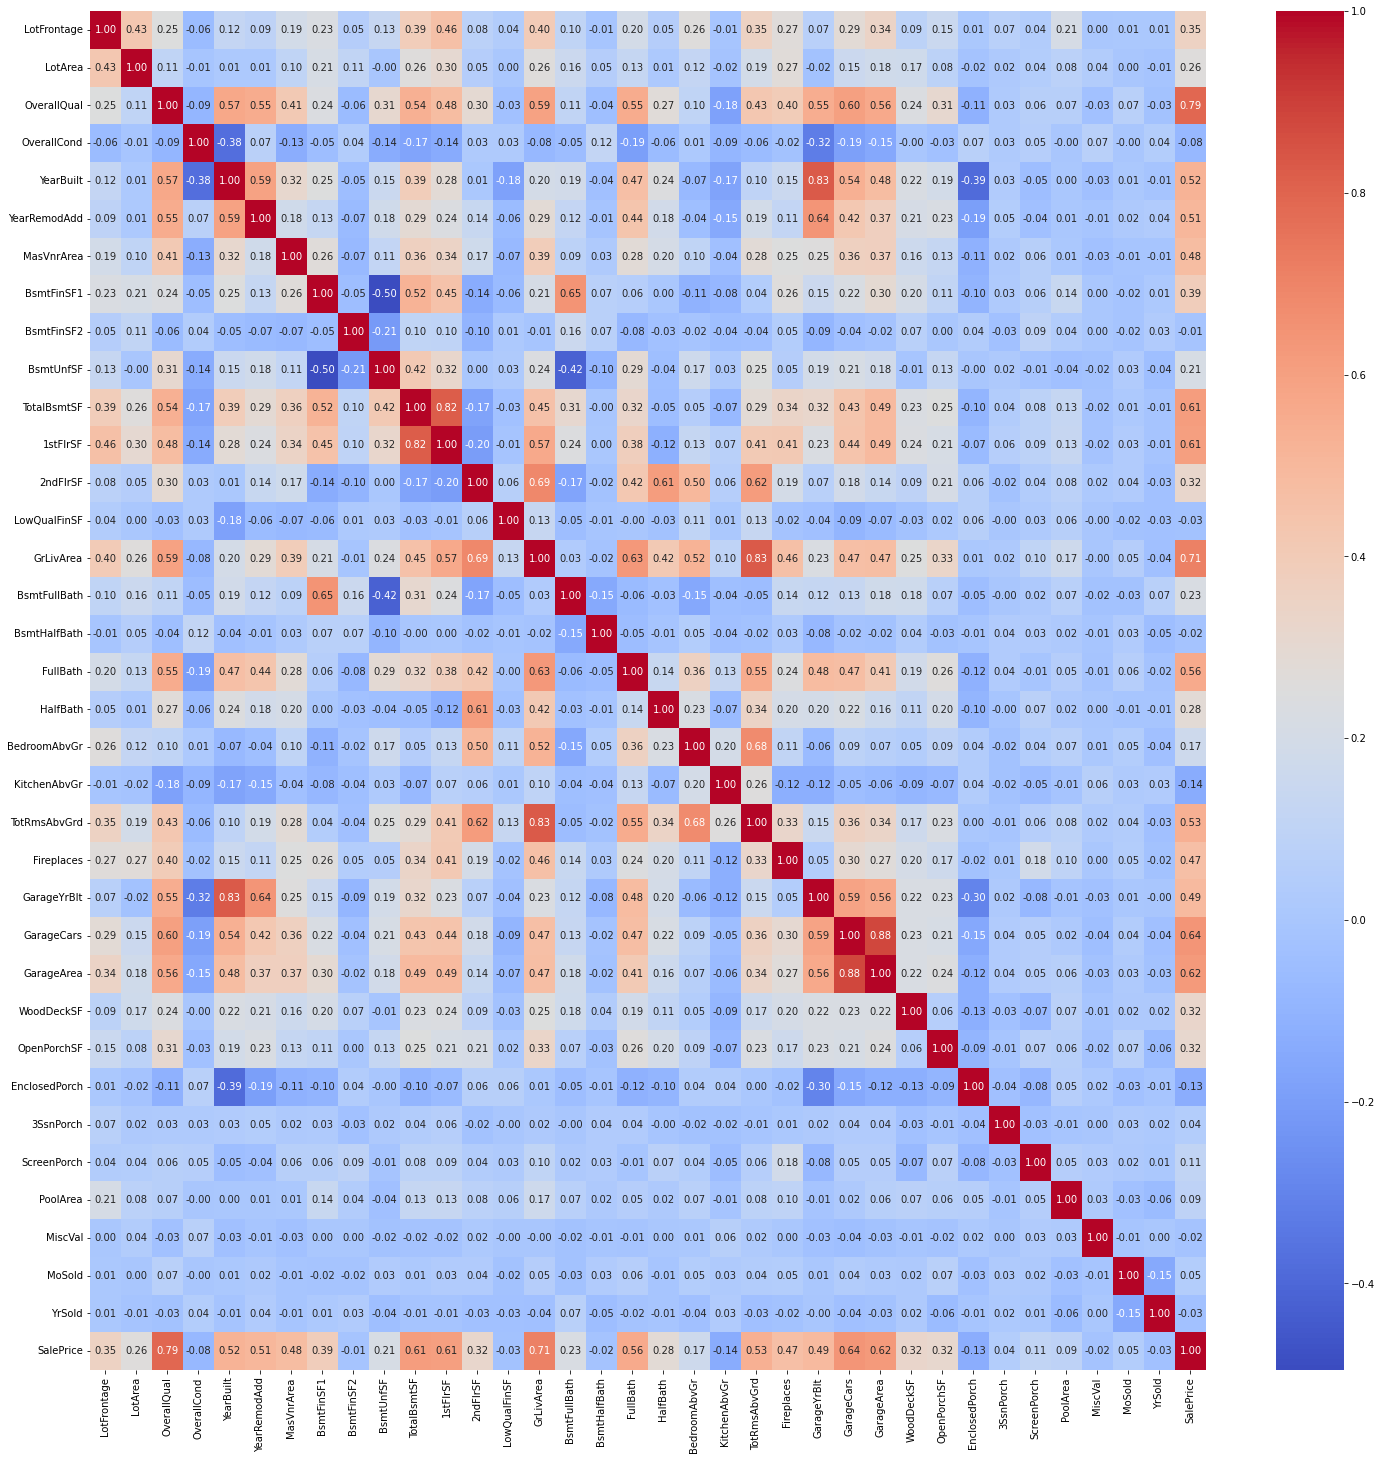

time: 9.58 s (started: 2022-02-21 17:09:11 -07:00)


In [11]:
# Plot the data using a heat map
corr_vals = df.corr()

# Check correlation between SalePrice and attributes
plt.rcParams['figure.figsize'] = 25, 25
plot_map = sns.heatmap(corr_vals,annot=True,fmt=".2f",cmap='coolwarm')

## Plot AveragePriceOfHome by Neighborhood

Text(0.5, 1.0, 'Average Price of Home by Neighborhood')

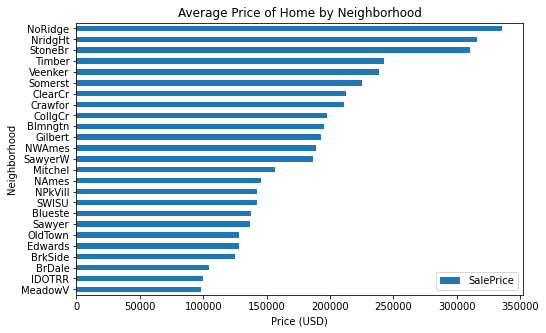

time: 391 ms (started: 2022-02-21 17:09:20 -07:00)


In [12]:
# Plot average price by neighborhood
a = pd.DataFrame(df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=True))
a.plot.barh(figsize = (8,5))
plt.xlabel('Price (USD)')
plt.title('Average Price of Home by Neighborhood')

## What factors should we consider for SalePrice? 

Factors to consider: 

- Year of Renovations (YearRemodAdd)
- Overall Quality
- Kitchen
- Roof
- Number of years since last Renovation ('YearsSinceReno')
- Age of House (YearBuilt)
- Total Square Footage (TotalSF)
- Lot Size
- Area of town (crime, race, earnings, etc.)
- Condition of House (HouseQuality)
- Basement quality etc..

In [13]:
# combine 1st, 2nd and finished basement sqft together (1stFlrSF, 2ndFlrSF)
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float32
 3   LotArea        1460 non-null   float32
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   float32
 17  OverallCond    1460 non-null   float32
 18  YearBuil

In [14]:
# Determine outliers for TotalSF
fig = px.histogram(df, x='TotalSF', 
                   marginal='box',
             histnorm = 'percent',
             title='TotalSF Histogram')

fig.show()

time: 1.47 s (started: 2022-02-21 17:09:21 -07:00)


Filter out all outlier values with a z-score > 3

In [15]:
# Filter other columns based on a single column

from scipy import stats
df_filtered = df[(np.abs(stats.zscore(df['TotalSF']) < 3))]

print("Old Shape: ", df.shape)
print("New Shape: ", df_filtered.shape)

Old Shape:  (1460, 81)
New Shape:  (1449, 81)
time: 16 ms (started: 2022-02-21 17:09:23 -07:00)


# Preprocessing

- Features and target selection
- Train-Test Split
- Numeric/Category Pipeline Setup
  - Define numerical and categorical columns in training data
  - Replace null numeric values with SimpleImputer()
  - Replace null categorical values (string, object, bool) with most frequent values by column
  - Encode each categorical value as unique category using OneHotEncoder()
  - Setup preprocessor ColumnTransformer Pipeline with numeric and category transformers as steps
    in process

## Features and Target selection

In [16]:
features = [x for x in df.columns if x not in ['SalePrice']]
X = df[features] # Prediction variable
y = df['SalePrice'] # Target variable

time: 0 ns (started: 2022-02-21 17:09:23 -07:00)


In [17]:
len(features)

80

time: 16 ms (started: 2022-02-21 17:09:23 -07:00)


## Train-Test Split

In [18]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

time: 16 ms (started: 2022-02-21 17:09:23 -07:00)


## Numeric and Category Pipeline setup 
 - XGBoost can ONLY interpret numeric values!
 - In order to interpret category and numeric values, all category values
   must be encoded using OneHotEncoder. Each string feature will be its own category

In [19]:

# Split the data up in to numerical data (int and float) and categorical 
# data (objects, names, words etc.)
num_cols = [cname for cname in X_train.columns 
            if X_train[cname].dtype == "float32"]

category_cols = [cname for cname in X_train.columns 
                 if X_train[cname].nunique() < 22 and 
                 X_train[cname].dtype == "object"]

# SimpleImputer is a function that replaces null cell values with the mean,
# median, most frequent or a fixed value based on the dataset used
numerical_transformer = SimpleImputer(strategy='constant')

# The same process can be applied to categorical values (strings, objects, etc.)
# and automated using the Pipeline function
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transform all data in columns using the preprocessor and ColumnTransformer function
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, category_cols)
])

time: 15 ms (started: 2022-02-21 17:09:23 -07:00)


# Create Root Mean Squared Log Error function (RMSLE)

RMSLE (Root Mean Square Log Error) must be used for this dataset to compare the predicted
data with the valid data. It's not a default scoring metric available
as a tool in Sci-kit Learn.

In [20]:
def root_mean_squared_log_error(y_valid, y_preds):
    # Calc rmse of log(y_test) and log(y_pred)
    
    if len(y_preds) != len(y_valid): return 'error_mismatch'
    y_preds_new = [math.log(x) for x in y_preds]
    y_valid_new = [math.log(x) for x in y_valid]
    return mean_squared_error(y_valid_new,y_preds_new,squared=False)

time: 0 ns (started: 2022-02-21 17:09:23 -07:00)


# Model Selection

## Model 1: DecisionTree

In [21]:
# Import model from sklearn
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)

# Setup a Pipeline processing function
tree_clf = Pipeline(steps=[('preprocessor',preprocessor),
                           ('tree_model',tree_model)
                          ])


# Fit the training dataset to the model
tree_clf.fit(X_train,y_train)

# Set tree_preds to the test feature data (X_test)
tree_preds = tree_clf.predict(X_test)

# Print the RMSLE results
print('RMSLE:', root_mean_squared_log_error(y_test,tree_preds))

RMSLE: 0.19147794560647968
time: 250 ms (started: 2022-02-21 17:09:23 -07:00)


## Model II: Random Forest regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

rand_clf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf',rf_model)
                           ])

# Fit the training data to the model
rand_clf.fit(X_train, y_train)

rand_preds = rand_clf.predict(X_test)

print('RMSLE:', root_mean_squared_log_error(y_test, rand_preds))

RMSLE: 0.14441345321009227
time: 9.23 s (started: 2022-02-21 17:09:24 -07:00)


## Model III: XGB Regressor

### Run Pipeline process and fit train-test data

In [23]:
xgb_model = XGBRegressor(n_estimators=1000,
                         max_depth=5, min_child_weight=1, 
                         gamma=0, 
                         booster='gbtree', 
                         learning_rate=0.02, 
                         objective='reg:squarederror', 
                         random_state=42)

# Run Pipeline
xgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('xgb_model', xgb_model)
                          ])

# Fit the model
xgb_clf.fit(X_train, y_train, xgb_model__verbose=False)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath...
                              gamma=0, gpu_id=-1,

time: 5.38 s (started: 2022-02-21 17:09:33 -07:00)


## Determine feature importance in XGBoost model

- Calc beta coefficients for each feature in the model
- Size of the beta coefficients for each feature will affect the Sale Price 

<AxesSubplot:>

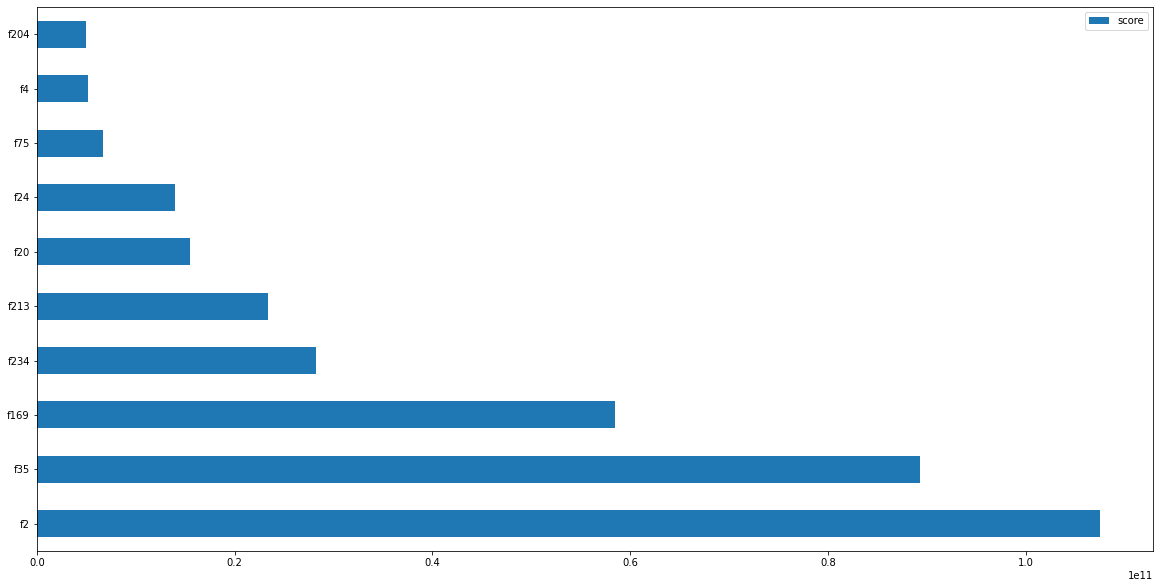

time: 219 ms (started: 2022-02-21 17:09:39 -07:00)


In [24]:
model = xgb_clf.named_steps['xgb_model']

feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 20 features

## Display top 10 features for XGBoost model

In [25]:
feats = {} # a dict to hold feature_name: feature_importance

feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["SCORE"]).sort_values(by = "SCORE", ascending=False)
data['FEATURE_IMPORTANCE_KEY'] = data.index
data.reset_index(inplace=True,drop=True)

# The size of the beta coefficient for each Feature in the model affects the SalePrice by a certain amount
df_beta = pd.DataFrame(zip(X_train.columns, model.get_booster().get_score(importance_type='gain')), columns=['FEATURE','FEATURE_IMPORTANCE_KEY'])

df_feat = pd.merge(df_beta, data, on='FEATURE_IMPORTANCE_KEY', how='inner')
df_feat = df_feat.sort_values(by='FEATURE_IMPORTANCE_KEY',ascending=False).reset_index(drop=True)
df_feat['FEATURE_IMPORTANCE_KEY'] = df_feat['FEATURE_IMPORTANCE_KEY'].str.replace('f','')
df_feat['FEATURE_IMPORTANCE_KEY'] = df_feat['FEATURE_IMPORTANCE_KEY'].astype('int32')
df_feat['SCORE'] = df_feat['SCORE']  / 10**6
df_feat = df_feat.sort_values(by='SCORE',ascending=False).reset_index(drop=True)
df_feat = df_feat.head(10)

# Display top 10 features for XGBoost model
fig = px.bar(df_feat,
             x='SCORE',
             y='FEATURE',
             hover_data=['FEATURE',
                        'SCORE'],
            title='XGBoost Regression Model: Feature Importance Score - Importance Type = Gain')
fig.show()

time: 125 ms (started: 2022-02-21 17:09:39 -07:00)


### Display predicted values (RMSLE) in XGBoost model

In [26]:
xgb_preds = xgb_clf.predict(X_test)

print('RMSLE:', root_mean_squared_log_error(y_test, xgb_preds))
print('\n')

RMSLE: 0.1397991521937399


time: 47 ms (started: 2022-02-21 17:09:39 -07:00)


Compare model values

In [27]:
print('Decision Tree RMSLE:', root_mean_squared_log_error(y_test, tree_preds))
print('Random Forest RMSLE:', root_mean_squared_log_error(y_test, rand_preds))
print('XGBoost Regressor RMSLE:', root_mean_squared_log_error(y_test, xgb_preds))

Decision Tree RMSLE: 0.19147794560647968
Random Forest RMSLE: 0.14441345321009227
XGBoost Regressor RMSLE: 0.1397991521937399
time: 15 ms (started: 2022-02-21 17:09:40 -07:00)


The XGBoost model performed the best out of the three models as 
it had the lowest RMSLE score

### Run GridSearchCV (CrossValidation) to select best parameters

Use the GridSearchCV model to determine the best parameters to select for 
Feature Engineering.

In [28]:
param_grid={"xgb_model__nlearning_rate": (0.05, 0.10, 0.15),
                        "xgb_model__nmax_depth": [6],
                        "xgb_model__nmin_child_weight": [1],
                        "xgb_model__ngamma":[0.0, 0.1, 0.2],
                        "xgb_model__ncolsample_bytree":[ 0.3, 0.4]}

grid = GridSearchCV(xgb_clf, 
            cv=3, param_grid=param_grid, 
            scoring=None, verbose=True, n_jobs=-1)

grid.fit(X_train, y_train)
print('\n All results:')
print(grid.cv_results_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
print('\n Best estimator:')
print(grid.best_estimator_)

In [ ]:
print('\n Best score:')
print(grid.best_score_ * 2 - 1)

In [ ]:
print('\n Best parameters:')
print(grid.best_params_)

In [ ]:
print('\n Feature Importances:')
feat_array = grid.best_estimator_.named_steps["xgb_model"].feature_importances_
df_feat = pd.DataFrame(feat_array.reshape(feat_array.shape), columns=['FEAT_IMPOR_SCORE']).sort_values(by='FEAT_IMPOR_SCORE',ascending=False).reset_index(drop=True)
df_feat.head(10)

## Model IV: Run high performance XGB regressor model

In [ ]:
hp_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

hp_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('hp_model', hp_model)
                     ])

hp_clf.fit(X_train, y_train, hp_model__verbose=False)

hp_preds = hp_clf.predict(X_test)

print('High Performance XGB Regressor RMSLE:', root_mean_squared_log_error(y_test, hp_preds))

# Final model Setup

Feature Engineering

In [ ]:
X.columns.to_list()

In [ ]:
print(set(X['SaleCondition']))

In [ ]:
print(X['YearBuilt'].head())
print('\n')
print(X['YearRemodAdd'].head())

In [ ]:
print(set(X['YrSold']))
print(set(X['MoSold']))

In [ ]:
print(set(X['ExterQual']))
print(set(X['ExterCond']))

In [ ]:
print(set(X['YearBuilt']))
print('\n')
print(set(X['OverallQual']))

In [ ]:
print(set(X['BedroomAbvGr']))
print(set(X['FullBath']))
print(set(X['HalfBath']))

### Feature notes

Based on the features in the columns, a few things stand out:
    
  - Subtracting YearBuilt from YearRemodAdd determines how recent renovation was
    completed (adds value to the house).
  - Lot geometry can be determined by dividing LotArea by LotFrontage. If the       lot is a good shape, it'll sell better. If it's strange than it may be less
    likely to sell.
  - Location in Ames? Is their high crime in the area? What is the income          level     in the neighborhood?  Is     it close to the downtown area or accessible to              shopping/university/transit/major road networks?
   
  - Features to combine:
       - YrSold and MoSold
       - Condition1 and Condition2
       - ExterQual and ExterCont
       - YearBuilt and OverallQual
       - Is there a finished basement?
       - Finished basement sqft
       
    

In [ ]:
# Make a copy of the features (X values)
X_feat_eng = X.copy()

In [ ]:
# Create the combined features
X_feat_eng['YearsSinceReno'] = X_feat_eng['YearRemodAdd'] - X_feat_eng['YearBuilt']
X_feat_eng['LotShape'] = X_feat_eng['LotArea'] / X_feat_eng['LotFrontage']
X_feat_eng['LandTopo'] = X_feat_eng['LandSlope'] + '_' + X_feat_eng['LandContour']
X_feat_eng['ValueRating'] = X_feat_eng['YearBuilt'] * X_feat_eng['OverallQual']
X_feat_eng['FinishedBsmt'] = X_feat_eng['BsmtFinSF1'] > 0
X_feat_eng['GarageVal'] = X_feat_eng['YearBuilt'] * X_feat_eng['GarageCars']
X_feat_eng['MiscVal'] = X_feat_eng['Fireplaces'] + X_feat_eng['OverallQual']  
X_feat_eng = X_feat_eng.drop(columns=['GarageCars'])


In [ ]:
# Split the data up in to numerical data (int and float) and categorical 
# data (objects, names, words etc.)
feat_num_cols = [cname for cname in X_feat_eng.columns 
            if X_feat_eng[cname].dtype in ['float32']]

feat_category_cols = [cname for cname in X_feat_eng.columns 
                 if X_feat_eng[cname].nunique() < 22 and 
                 X_feat_eng[cname].dtype in ['object', 'bool']]

# SimpleImputer is a function that replaces null cell values with the mean,
# median, most frequent or a fixed value based on the dataset used
feat_numerical_transformer = SimpleImputer(strategy='constant')

# The same process can be applied to categorical values (strings, objects, etc.)
# and automated using the Pipeline function
feat_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transform all data in columns using the preprocessor and ColumnTransformer function
feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', feat_numerical_transformer, feat_num_cols),
        ('cat', feat_categorical_transformer, feat_category_cols)
])


### Run the final Feature model (XGBRegressor)

In [ ]:
feature_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=0.0, monotone_constraints='()',
             n_estimators=1250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)


feature_clf = Pipeline(steps=[('feature_preprocessor', feature_preprocessor),
                                ('feature_model', feature_model)           
                                ])
# Perform train-test split
feature_X_train, feature_X_valid, feature_y_train, feature_y_valid = train_test_split(X_feat_eng, y, random_state=42)

# Fit the training dataset
feature_clf.fit(feature_X_train, feature_y_train)

### Check feature importance

In [ ]:
model = feature_clf.named_steps['feature_model']

feats = {} # a dict to hold feature_name: feature_importance

feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["SCORE"]).sort_values(by = "SCORE", ascending=False)
data['FEATURE_IMPORTANCE_KEY'] = data.index
data.reset_index(inplace=True,drop=True)

# The size of the beta coefficient for each Feature in the model affects the SalePrice by a certain amount
df_beta = pd.DataFrame(zip(X_train.columns, model.get_booster().get_score(importance_type='gain')), columns=['FEATURE','FEATURE_IMPORTANCE_KEY'])

df_feat = pd.merge(df_beta, data, on='FEATURE_IMPORTANCE_KEY', how='inner')
df_feat = df_feat.sort_values(by='FEATURE_IMPORTANCE_KEY',ascending=True).reset_index(drop=True)
df_feat['FEATURE_IMPORTANCE_KEY'] = df_feat['FEATURE_IMPORTANCE_KEY'].str.replace('f','')
df_feat['FEATURE_IMPORTANCE_KEY'] = df_feat['FEATURE_IMPORTANCE_KEY'].astype('int32')
df_feat['SCORE'] = df_feat['SCORE'] / 10**6
df_feat = df_feat.sort_values(by='SCORE',ascending=False).reset_index(drop=True)
df_feat = df_feat.head(10)

# Display top 10 features for XGBoost model
fig = px.bar(df_feat,
             x='SCORE',
             y='FEATURE',
             hover_data=['FEATURE',
                        'SCORE'],
            title='XGBoost Final Regression Model: Feature Importance Score - Importance Type = Gain')

fig.show()

In [ ]:
# Feature predictions using validation feature data (test)
feature_preds = feature_clf.predict(feature_X_valid)

print('Final XGBRegressor Model RMSLE:', root_mean_squared_log_error(feature_y_valid, feature_preds))